# Setting Up - Install Packages in the Workspace
Before you move on to the project instruction, follow the cells below to ensure you have the necessary packages installed. 
The cells below will also educate you on installing newer pinned packages, should you need them in the future. 

In [1]:
# Step 1. Update the PATH env var. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/student/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.10/site-packages"
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
# Check the version of any specific package
!python -m pip freeze | grep numpy

numpy @ file:///work/mkl/numpy_and_numpy_base_1682953417311/work


In [3]:
!pip install protobuf google


Defaulting to user installation because normal site-packages is not writeable


# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [4]:
!pip -q install .

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [5]:
# Restart the Kernel. 
# If you skip this step, your notebook may not be able to import the packages well. 


In [6]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

Found path: /data/Banana_Linux_NoVis/Banana.x86_64
Mono path[0] = '/data/Banana_Linux_NoVis/Banana_Data/Managed'
Mono config path = '/data/Banana_Linux_NoVis/Banana_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [9]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [10]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DuelingQNetwork(nn.Module):
    """Dueling DQN Architecture."""

    def __init__(self, state_size, action_size, seed, fc1_units=32, fc2_units=32):
        """
        The architecture splits into two paths (streams) after the feature layer:
        1. Value Stream (V): Estimates the value of the state itself.
        2. Advantage Stream (A): Estimates the advantage of each action.
        """
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Feature extraction layer (shared)
        self.fc1 = nn.Linear(state_size, fc1_units)
        
        # --- Value Stream (V) ---
        self.fc2_val = nn.Linear(fc1_units, fc2_units)
        self.fc3_val = nn.Linear(fc2_units, 1) # Outputs a single value for the state
        
        # --- Advantage Stream (A) ---
        self.fc2_adv = nn.Linear(fc1_units, fc2_units)
        self.fc3_adv = nn.Linear(fc2_units, action_size) # Outputs value for each action

    def forward(self, state):
        # Shared features
        x = F.relu(self.fc1(state))
        
        # Value stream
        val = F.relu(self.fc2_val(x))
        V = self.fc3_val(val)
        
        # Advantage stream
        adv = F.relu(self.fc2_adv(x))
        A = self.fc3_adv(adv)
        
        # Recombine: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        # We subtract the mean to center the advantage (stability trick)
        return V + (A - A.mean(dim=1, keepdim=True))

In [12]:
import numpy as np
import random
from collections import namedtuple, deque
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [13]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda:0
GPU Name: Tesla T4


Episode 100	Average Score: 0.84
Episode 200	Average Score: 4.20
Episode 300	Average Score: 7.14
Episode 400	Average Score: 10.18
Episode 500	Average Score: 12.63
Episode 509	Average Score: 13.02
Environment solved in 409 episodes!


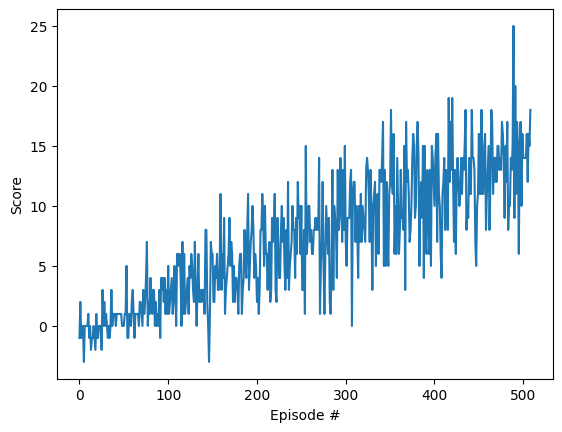

In [14]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt

# 1. LOAD ENVIRONMENT
# -------------------
# Check if /data/ exists, otherwise use a local path (for when you download it later)
# import os
# if os.path.exists("/data/Banana_Linux_NoVis/Banana.x86_64"):
#     env_path = "/data/Banana_Linux_NoVis/Banana.x86_64"
# else:
#     env_path = "Banana_Linux_NoVis/Banana.x86_64" # fallback for local
    
# env = UnityEnvironment(file_name=env_path)

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

# 2. CREATE AGENT
# ---------------
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# 3. TRAIN
# --------
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 13.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

scores = dqn()

# 4. PLOT
# -------
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
import os
import base64
from IPython.display import HTML

def create_download_link(file_path, title="Download file"):
    if not os.path.exists(file_path):
        return f"File {file_path} not found."
    
    with open(file_path, 'rb') as f:
        data = f.read()
    b64 = base64.b64encode(data).decode()
    payload = b64
    
    html = f'<a download="{os.path.basename(file_path)}" href="data:application/octet-stream;base64,{payload}" target="_blank">{title}</a>'
    return HTML(html)

# 1. Save the plot to a file
plt.savefig('scores_plot.png')

# 2. Display download links
print("Click the links below to download your project files:")
display(create_download_link('checkpoint.pth', '1. Download Model Checkpoint (checkpoint.pth)'))
display(create_download_link('scores_plot.png', '2. Download Training Plot (scores_plot.png)'))

Click the links below to download your project files:


<Figure size 640x480 with 0 Axes>